# 直接调用XGBoost
该示例中我们在xgboost安装包中自带的Mushroom数据集演示直接调用XGBoost
1. 读取数据--> DMatrix
2. 设置参数
3. 模型训练：train/cv
    3.1: train with 在校验集上early stop
    3.2: cv
4. 预测

## 导入必要的工具包

In [27]:
# 导入必要的工具包
import xgboost as xgb

# 计算分类正确率
from sklearn.metrics import accuracy_score

## 数据读取

XGBoost可以加载libsvm格式的文本数据，libsvm的文件格式（稀疏特征）如下：
1 101:1.2 102:0.03
0 1:2.1 10001:300 10002:400
...

每一行表示一个样本，第一行的开头的“1”是样本的标签。“101”和“102”为特征索引，'1.2'和'0.03' 为特征的值。
在两类分类中，用“1”表示正样本，用“0” 表示负样本。也支持[0,1]表示概率用来做标签，表示为正样本的概率。

下面的示例数据需要我们通过一些蘑菇的若干属性判断这个品种是否有毒。
UCI数据描述：http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/ ，
每个样本描述了蘑菇的22个属性，比如形状、气味等等（将22维原始特征用加工后变成了126维特征，
并存为libsvm格式)，然后给出了这个蘑菇是否可食用。其中6513个样本做训练，1611个样本做测试。

XGBoost加载的数据存储在对象DMatrix中
XGBoost自定义了一个数据矩阵类DMatrix，优化了存储和运算速度
DMatrix文档：http://xgboost.readthedocs.io/en/latest/python/python_api.html

In [28]:
# read in data，数据在xgboost安装的路径下的demo目录,现在我们将其copy到当前代码下的data目录
dpath = './data/'
dtrain = xgb.DMatrix(dpath + 'agaricus.txt.train')
dtest = xgb.DMatrix(dpath + 'agaricus.txt.test')

查看数据情况

In [29]:
dtrain.num_col()

127L

In [30]:
dtrain.num_row()

6513L

In [31]:
dtest.num_row()

1611L

## 训练参数设置

max_depth： 树的最大深度。缺省值为6，取值范围为：[1,∞]
eta：学习率。为了防止过拟合，更新过程中用到的收缩步长。
eta通过缩减特征的权重使提升计算过程更加保守。缺省值为0.3，取值范围为：[0,1]
silent：取0时表示打印出运行时信息，取1时表示以缄默方式运行，不打印运行时信息。缺省值为0
objective： 定义学习任务及相应的学习目标，“binary:logistic” 表示二分类的逻辑回归问题，输出为概率。

其他参数取默认值。

In [32]:
# specify parameters via map
param = {'max_depth':2, 'eta':1, 'silent':0, 'objective':'binary:logistic' }

## 训练模型

有了参数列表和数据就可以训练模型了 

In [33]:
# 设置boosting迭代计算次数，即若学习器（决策树）的数目
num_round = 2

#import time
#starttime = time.clock()

bst = xgb.train(param, dtrain, num_round)

#endtime = time.clock()
#print (endtime - starttime)

查看模型在训练集上的分类性能

XGBoost预测的输出是概率。这里蘑菇分类是一个二类分类问题，输出值是样本为第一类的概率。
我们需要将概率值转换为0或1。

In [34]:
train_preds = bst.predict(dtrain)
train_predictions = [round(value) for value in train_preds]
y_train = dtrain.get_label()
train_accuracy = accuracy_score(y_train, train_predictions)
print ("Train Accuary: %.2f%%" % (train_accuracy * 100.0))

Train Accuary: 97.77%


## 测试

模型训练好后，可以用训练好的模型对测试数据进行预测

In [35]:
# make prediction
preds = bst.predict(dtest)

检查模型在测试集上的正确率
XGBoost预测的输出是概率，输出值是样本为第一类的概率。我们需要将概率值转换为0或1。

In [36]:
predictions = [round(value) for value in preds]

In [37]:
y_test = dtest.get_label()
test_accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Test Accuracy: 97.83%


## 模型可视化

调用XGBoost工具包中的plot_tree，在显示
要可视化模型需要安装graphviz软件包
ip install graphviz

plot_tree（）的三个参数：
1. 模型
2. 树的索引，从0开始
3. 显示方向，缺省为竖直，‘LR'是水平方向

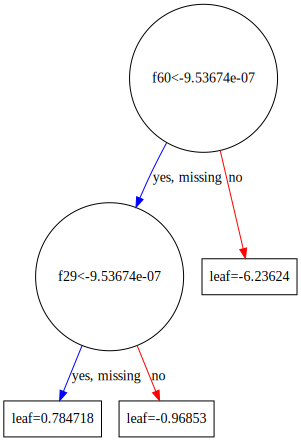

In [38]:
from matplotlib import pyplot
import graphviz
#xgb.plot_tree(bst, num_trees=0, rankdir= 'LR' )
#pyplot.show()

#xgb.plot_tree(bst,num_trees=1, rankdir= 'LR' )
#pyplot.show()
#xgb.to_graphviz(bst,num_trees=0)
xgb.to_graphviz(bst,num_trees=1)

## 采用交叉验证得到最佳的n_estimators

In [39]:
n_estimators = 1000
early_stopping_rounds = 10
cv_result = xgb.cv(param, dtrain, num_boost_round=n_estimators, folds =5,
             metrics='logloss', early_stopping_rounds=early_stopping_rounds)
  


In [40]:
cv_result

,test-logloss-mean,test-logloss-std,train-logloss-mean,train-logloss-std
0,0.233672,0.004222,0.233574,0.002588
1,0.137153,0.004188,0.137062,0.001687
2,0.083247,0.001000,0.083167,0.000856
3,0.057180,0.001501,0.057117,0.001012
4,0.042534,0.000609,0.041473,0.000507
5,0.028232,0.004339,0.028354,0.001794
6,0.019509,0.001554,0.019259,0.000156
7,0.015521,0.001268,0.014934,0.000269
8,0.011678,0.000404,0.011424,0.000466
9,0.009882,0.000648,0.009627,0.000080


In [41]:
#最佳参数n_estimators
n_estimators = cv_result.shape[0]
print("Best n_estimators:", n_estimators)
    
# 采用交叉验证得到的最佳参数n_estimators，训练模型
bst = xgb.train(param, dtrain, n_estimators)

('Best n_estimators:', 148)


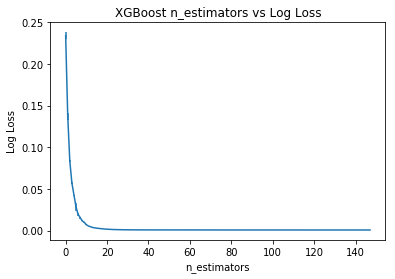

In [14]:
# plot
test_means = cv_result['test-logloss-mean']
test_stds = cv_result['test-logloss-std'] 

x_axis = range(0, cv_result.shape[0])
        
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')

pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )

pyplot.show()

In [15]:
# make prediction
preds = bst.predict(dtest)
y_pred = [round(value) for value in preds]
y_test = dtest.get_label()
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Test Accuracy: 100.00%


### 使用XGBoost内嵌的函数，按特征重要性排序

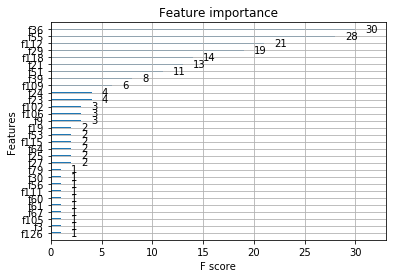

In [16]:
# plot feature importance using built-in function
from xgboost import plot_importance
plot_importance(bst)
pyplot.show()